# Домашнее задание "Варианционные автоэнкодеры"


**Автор**: Ермекова Асель

В этом домашнем задании вам предстоит реализовать VAE для датасета картинок MNIST.

Вы научитесь обучать вариационный автоэнкодер (VAE) генерировать новые изображения с нуля. А также сможете управлять генерацией, указывая желаемый класс объекта, и оценивать качество результата с помощью метрики FID.

Это домашнее задание состоит из двух частей:

- **I часть.** Реализовать безусловную генерацию картинок при помощи VAE тренированную на датасете MNIST и оценить качество по метрике FID.
- **II часть.** Реализовать условную генерацию по классу и оценить качество по метрике FID.


Установите библиотеку для подсчета FID:


In [5]:
# !pip install pytorch-fid

## **I часть. Unconditional VAE (6 баллов)**


### Библиотеки


In [1]:
# TODO
# Импортните любые необходимые вам библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.cuda.empty_cache()

### Датасет.


**Задание**: Скачайте датасет MNIST и подготовьте train dataloader.


In [3]:
# --- Подготовка данных ---
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Тренировочных изображений: {len(train_dataset)}")
print(f"Тестовых изображений: {len(test_dataset)}")

Тренировочных изображений: 60000
Тестовых изображений: 10000


**Задание**: Для FID сохраните 10k реальных изображений из MNIST test части в папку


In [11]:
# TODO: Для FID сохраните 10k реальных изображений из MNIST test части в папку
def save_images_to_folder(image_tensors, save_dir, start_index=0, denormalize=True):
    """
    Сохраняет тензоры изображений в папку как PNG файлы.

    Args:
        image_tensors: Список/тензор изображений [N, C, H, W] или [N, H, W]
        save_dir: Путь для сохранения
        start_index: Начальный индекс для имен файлов
        denormalize: Денормализовать ли из [-1, 1] в [0, 1]
    """
    os.makedirs(save_dir, exist_ok=True)

    for i, img_tensor in enumerate(image_tensors):
        img = img_tensor.clone()

        # Денормализация если нужно
        if denormalize and img.min() < 0:
            img = (img * 0.5 + 0.5).clamp(0, 1)

        # Конвертируем в PIL и сохраняем
        img_pil = transforms.ToPILImage()(img.cpu())
        img_pil.save(f'{save_dir}/{start_index + i:05d}.png')

    print(f"Сохранено {len(image_tensors)} изображений в {save_dir}")

In [10]:

# Пример использования для реальных изображений:
real_images = []
for i in range(10000):
    img_tensor, _ = test_dataset[i]
    real_images.append(img_tensor)

save_images_to_folder(real_images, './mnist_vae_real')

Сохранено 10000 изображений в ./mnist_vae_real


**Задание**: Визуализируйте 5 рандомных сэмплов из тренировочных данных и 5 сэмплов из тестовых данных


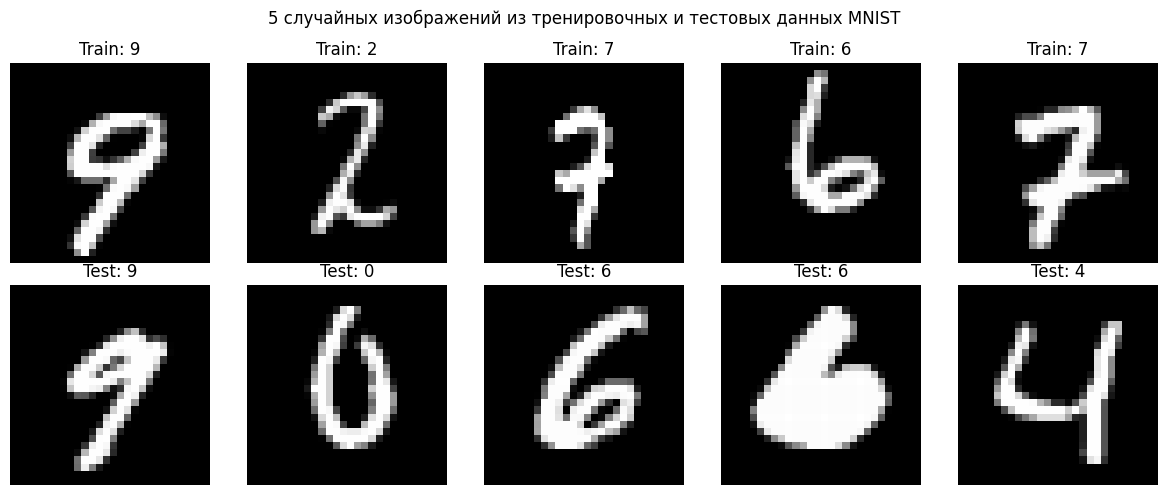

In [11]:
# TODO

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Тренировочные данные
for i in range(5):
    idx = np.random.randint(len(train_dataset))
    img, label = train_dataset[idx]

    # Денормализуем изображение
    img = (img * 0.5 + 0.5).numpy().squeeze()

    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'Train: {label}')
    axes[0, i].axis('off')

# Тестовые данные
for i in range(5):
    idx = np.random.randint(len(test_dataset))
    img, label = test_dataset[idx]

    # Денормализуем изображение
    img = (img * 0.5 + 0.5).numpy().squeeze()

    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f'Test: {label}')
    axes[1, i].axis('off')

plt.suptitle('5 случайных изображений из тренировочных и тестовых данных MNIST')
plt.tight_layout()
plt.show()

### Модель


**Задание**: Реализуйте VAE архитектуру


In [47]:
# TODO: Реализуйте VAE (безусловный)

class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Энкодер с большей емкостью
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Декодер с большей емкостью
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

### Loss


**Задание**: Напишите VAE Loss


In [48]:
# TODO: Реализуйте функцию потерь VAE
def vae_loss(recon_x, x, mu, logvar):
    x_denorm = x.view(-1, 28*28)
    # Reconstruction loss: BCE (since output is sigmoid)
    recon_loss = F.binary_cross_entropy(recon_x, x_denorm, reduction='sum')

    # KL divergence: D_KL(q(z|x) || p(z))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

### Тренировка


**Задание**: Обучите модель на датасете MNIST.


In [49]:
latent_dim = 32  # MNIST VAEs often use 20–64
epochs = 40
lr = 3e-4
img_size = 28
channels = 1

In [50]:
# TODO: Обучите модель
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Обучение...
print("Starting VAE training...")
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data.view(-1, 28*28), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch: {epoch} Average loss: {avg_train_loss:.4f}')

print("VAE training complete.")

Starting VAE training...
Epoch: 1 Average loss: 204.9274
Epoch: 2 Average loss: 153.2717
Epoch: 3 Average loss: 135.5399
Epoch: 4 Average loss: 126.0443
Epoch: 5 Average loss: 120.5408
Epoch: 6 Average loss: 116.6819
Epoch: 7 Average loss: 113.8743
Epoch: 8 Average loss: 111.8018
Epoch: 9 Average loss: 110.1700
Epoch: 10 Average loss: 108.8145
Epoch: 11 Average loss: 107.7299
Epoch: 12 Average loss: 106.7979
Epoch: 13 Average loss: 106.0080
Epoch: 14 Average loss: 105.2881
Epoch: 15 Average loss: 104.6606
Epoch: 16 Average loss: 104.0905
Epoch: 17 Average loss: 103.7034
Epoch: 18 Average loss: 103.3105
Epoch: 19 Average loss: 102.8939
Epoch: 20 Average loss: 102.5557
Epoch: 21 Average loss: 102.2080
Epoch: 22 Average loss: 101.9065
Epoch: 23 Average loss: 101.6909
Epoch: 24 Average loss: 101.4004
Epoch: 25 Average loss: 101.1523
Epoch: 26 Average loss: 100.9468
Epoch: 27 Average loss: 100.7343
Epoch: 28 Average loss: 100.5108
Epoch: 29 Average loss: 100.3325
Epoch: 30 Average loss: 100

### Метрика


В этом разделе вам необходимо посчитать метрику FID.


**Что такое FID?**

**FID (Fréchet Inception Distance)** — это метрика качества генеративных моделей для изображений, которая измеряет **расстояние между распределениями признаков реальных и сгенерированных изображений** в пространстве предобученной нейросети (обычно Inception-v3).

Чем **ниже FID**, тем **ближе** сгенерированные изображения к реальным — как по **качеству**, так и по **разнообразию**.

Формула FID основана на предположении, что признаки в этом пространстве приблизительно распределены как **многомерное нормальное распределение**:

$$
\text{FID} = \|\mu_r - \mu_g\|^2 + \mathrm{Tr}\left( \Sigma_r + \Sigma_g - 2\sqrt{\Sigma_r \Sigma_g} \right)
$$

где:

- $(\mu_r, \Sigma_r)$ — среднее и ковариационная матрица признаков **реальных** изображений,
- $(\mu_g, \Sigma_g)$ — то же для **сгенерированных** изображений,
- $\mathrm{Tr}(\cdot)$ — след матрицы.

> 🔹 FID = 0 означает полное совпадение распределений.  
> 🔹 Чем выше FID ↑ , тем качество или разнообразие генерации ниже ↓.


**Как считать FID на MNIST?**

Вычислите FID с помощью библиотеки [`pytorch-fid`](https://github.com/mseitzer/pytorch-fid):

```bash
python -m pytorch_fid real_mnist/ fake_mnist/ --device cuda
```

> **Важно**: несмотря на то, что признаки Inception-v3 не оптимальны для рукописных цифр, FID остаётся полезной **относительной метрикой** — она позволяет сравнивать разные модели между собой при одинаковых условиях предобработки.


**Задание:** Сгенерируйте и сохраните 10 тыс. изображений, выберите 10 тыс. реальных изображений из MNIST тестовой выборки и посчитайте FID между реальными и сгенерированными изображениями.


In [51]:
# TODO: Сгенерируйте и сохраните 10 тыс. изображений для FID в папке mnist_vae_fake

num_images = 10000
save_dir = './mnist_vae_fake'

model.eval()
all_generated = []

with torch.no_grad():
    for batch_start in range(0, num_images, batch_size):
        batch_end = min(batch_start + batch_size, num_images)
        current_batch_size = batch_end - batch_start

        # Генерация
        z = torch.randn(current_batch_size, latent_dim).to(device)
        generated = model.decode(z).view(-1, 1, 28, 28)
        all_generated.append(generated.cpu())

# Объединяем все изображения
all_generated = torch.cat(all_generated, dim=0)

# Сохраняем
save_images_to_folder(all_generated, save_dir, denormalize=False)

Сохранено 10000 изображений в ./mnist_vae_fake


In [52]:
# Чтобы вычислить FID, запустите в терминале:
# !pip install pytorch-fid
!python -m pytorch_fid mnist_vae_real mnist_vae_fake --device cuda

FID:  29.175885140926226


## **II Часть. Conditional VAE (6 баллов)**


Мы уже научились обучать обычный VAE на датасете картинок и получать новые картинки. Давайте теперь научимся обучать модель, которая сможет генерировать не просто рандомную картинку, которая похожа на картинки из датасета, а картинку из конкретного класса. Например, в MNIST датасете 10 классов (от 1 до 10) и мы хотим говорить модели "Сгенерируй мне только конкретно картинку с числом 3." и она должна теперь уже сгенерировать только картинку с числом 3. Как раз Conditional VAE это должен уметь делать и генерировать картинку, обуславливаясь на конкретный класс.

**Задание**. В этой части домашнего задания вам предстоит обучить Conditional VAE на MNIST. Это значит, что модель на вход должна принимать картинку и класс картинки.

**Метрика**. Вам нужно сгенерировать 1000 сэмплов на каждый класс и посчитать FID для каждого класса.


In [35]:
# TODO: Реализуйте Condiional VAE — добавьте one-hot класс как вход в encoder и decoder
class CVAE(nn.Module):
    def __init__(self, latent_dim=32, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Энкодер с большей емкостью
        self.encoder = nn.Sequential(
            nn.Linear(28*28 + num_classes, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Декодер с большей емкостью
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        combined = torch.cat([x, c], dim=1)
        h = self.encoder(combined)
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 28*28), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std


def cvae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(
        recon_x,
        x.view(-1, 28*28),
        reduction='sum'
    )

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [36]:
cvae_latent_dim = 64
cvae_epochs = 60
cvae_lr = 3e-4

# TODO: Обучите CVAE

model_cvae = CVAE(cvae_latent_dim).to(device)
optimizer_cvae = optim.Adam(model_cvae.parameters(), lr=cvae_lr)

# Training loop
print("Starting CVAE training...")
for epoch in range(1, cvae_epochs + 1):
    model_cvae.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        # Преобразуем метки в one-hot векторы
        y_one_hot = F.one_hot(labels, num_classes=10).float()

        optimizer_cvae.zero_grad()
        recon_batch, mu, logvar = model_cvae(data, y_one_hot)
        loss = cvae_loss(recon_batch, data.view(-1, 28*28), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer_cvae.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch: {epoch} Average loss: {avg_train_loss:.4f}')

print("CVAE training complete.")

Starting CVAE training...
Epoch: 1 Average loss: 166.6267
Epoch: 2 Average loss: 128.4969
Epoch: 3 Average loss: 117.3528
Epoch: 4 Average loss: 111.1352
Epoch: 5 Average loss: 107.4275
Epoch: 6 Average loss: 104.8845
Epoch: 7 Average loss: 103.1849
Epoch: 8 Average loss: 101.9968
Epoch: 9 Average loss: 100.7933
Epoch: 10 Average loss: 100.0324
Epoch: 11 Average loss: 99.2970
Epoch: 12 Average loss: 98.7411
Epoch: 13 Average loss: 98.1627
Epoch: 14 Average loss: 97.6168
Epoch: 15 Average loss: 97.3413
Epoch: 16 Average loss: 96.9321
Epoch: 17 Average loss: 96.6320
Epoch: 18 Average loss: 96.3284
Epoch: 19 Average loss: 96.0344
Epoch: 20 Average loss: 95.6899
Epoch: 21 Average loss: 95.4673
Epoch: 22 Average loss: 95.2806
Epoch: 23 Average loss: 95.1237
Epoch: 24 Average loss: 94.9157
Epoch: 25 Average loss: 94.7319
Epoch: 26 Average loss: 94.4677
Epoch: 27 Average loss: 94.3678
Epoch: 28 Average loss: 94.2290
Epoch: 29 Average loss: 94.0009
Epoch: 30 Average loss: 93.9801
Epoch: 31 Ave

In [44]:
# # TODO: Сохраните 1000 сэмплов для каждого класса из реального датасета MNIST тестовой части
images_per_class = 1000

# Группируем по классам
real_by_class = {i: [] for i in range(10)}
for img, label in test_dataset:
    real_by_class[label].append(img)

# Сохраняем по 1000 для каждого класса в отдельную папку
for digit in range(10):
    print(f"Сохранение реальных изображений класса {digit}...")
    class_images = real_by_class[digit][:images_per_class]
    class_dir = os.path.join('./mnist_сvae_real_2', f'class_{digit}')
    os.makedirs(class_dir, exist_ok=True)
    save_images_to_folder(class_images, class_dir, denormalize=False)

Сохранение реальных изображений класса 0...
Сохранено 980 изображений в ./mnist_сvae_real_2/class_0
Сохранение реальных изображений класса 1...
Сохранено 1000 изображений в ./mnist_сvae_real_2/class_1
Сохранение реальных изображений класса 2...
Сохранено 1000 изображений в ./mnist_сvae_real_2/class_2
Сохранение реальных изображений класса 3...
Сохранено 1000 изображений в ./mnist_сvae_real_2/class_3
Сохранение реальных изображений класса 4...
Сохранено 982 изображений в ./mnist_сvae_real_2/class_4
Сохранение реальных изображений класса 5...
Сохранено 892 изображений в ./mnist_сvae_real_2/class_5
Сохранение реальных изображений класса 6...
Сохранено 958 изображений в ./mnist_сvae_real_2/class_6
Сохранение реальных изображений класса 7...
Сохранено 1000 изображений в ./mnist_сvae_real_2/class_7
Сохранение реальных изображений класса 8...
Сохранено 974 изображений в ./mnist_сvae_real_2/class_8
Сохранение реальных изображений класса 9...
Сохранено 1000 изображений в ./mnist_сvae_real_2/cla

In [45]:
# TODO: Сгенерируйте 1000 сэмплов для каждого класса при помощи CVAE модели

model_cvae.eval()

with torch.no_grad():
    for digit in range(10):
        print(f"Генерация класса {digit}...")
        class_images = []

        for i in range(0, images_per_class, batch_size):
            current_batch = min(batch_size, images_per_class - i)

            # Генерация
            z = torch.randn(current_batch, cvae_latent_dim).to(device)
            labels = torch.full((current_batch,), digit, device=device)
            y_one_hot = F.one_hot(labels, num_classes=10).float()

            generated = model_cvae.decode(z, y_one_hot).view(-1, 1, 28, 28)
            class_images.append(generated.cpu())

        # Объединяем и сохраняем для текущего класса
        class_images = torch.cat(class_images, dim=0)
        class_dir = os.path.join('./mnist_cvae_fake_2', f'class_{digit}')
        os.makedirs(class_dir, exist_ok=True)
        save_images_to_folder(class_images, class_dir, denormalize=False)



Генерация класса 0...
Сохранено 1000 изображений в ./mnist_cvae_fake_2/class_0
Генерация класса 1...
Сохранено 1000 изображений в ./mnist_cvae_fake_2/class_1
Генерация класса 2...
Сохранено 1000 изображений в ./mnist_cvae_fake_2/class_2
Генерация класса 3...
Сохранено 1000 изображений в ./mnist_cvae_fake_2/class_3
Генерация класса 4...
Сохранено 1000 изображений в ./mnist_cvae_fake_2/class_4
Генерация класса 5...
Сохранено 1000 изображений в ./mnist_cvae_fake_2/class_5
Генерация класса 6...
Сохранено 1000 изображений в ./mnist_cvae_fake_2/class_6
Генерация класса 7...
Сохранено 1000 изображений в ./mnist_cvae_fake_2/class_7
Генерация класса 8...
Сохранено 1000 изображений в ./mnist_cvae_fake_2/class_8
Генерация класса 9...
Сохранено 1000 изображений в ./mnist_cvae_fake_2/class_9


In [46]:
# TODO: Посчитайте FID для каждого класса между сгенерированными и реальными изображениями
# Example:
for digit in range(10):
    real_dir = f'mnist_сvae_real_2/class_{digit}'
    cvae_dir = f'mnist_cvae_fake_2/class_{digit}'
    
    print(f"\nClass {digit}")
    !python -m pytorch_fid {real_dir} {cvae_dir} --device cuda




Class 0
FID:  44.06605182890465

Class 1
FID:  36.99437130394092

Class 2
FID:  32.828004503387206

Class 3
FID:  29.20939690391745

Class 4
FID:  32.25328371301549

Class 5
FID:  31.220000472046564

Class 6
FID:  29.391220905397347

Class 7
FID:  35.19655413393755

Class 8
FID:  31.73889143660955

Class 9
FID:  34.35183328288531
